In [1]:
#import packages

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import glob
%matplotlib inline

# 1.Camera calibration

In [2]:
#define a function to undistort the given camera

def cam_undist(images, nx, ny):
    objpoints = []
    imgpoints = []
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)    
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        #print(i, ret)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(\
            objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

## calibrate the camera first

In [3]:
#1. load the calibration images
images = glob.glob(r"../CarND-Advanced-Lane-Lines/camera_cal/*.jpg")
#2. calculate the matrix and distortion coefficient
mtx, dst = cam_undist(images, nx = 9, ny = 6)

## provide an example of a distortion corrected calibration image.

True

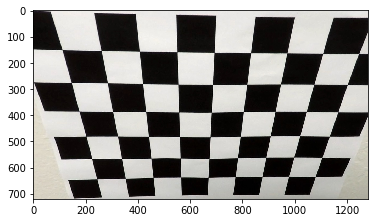

In [4]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration2.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
undist_show = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
plt.imshow(undist_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/calibration2_out.jpg', undist)

# 2. Create an unwarped thresholded binary image

In [5]:
#define a function to create a sobel thresholded binary image
def abs_sobel_thresh(img, orient = 'x', sobel_kernel = 3, 
                     thresh = (0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, \
                          ksize = sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, \
                          ksize = sobel_kernel)
    else:
        print("Illegal orient input. \
        It should be 'x' or 'y'.\n")
        return
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & \
                  (scaled_sobel < thresh[1])] = 1
    return binary_output
    

In [6]:
#define a function to create a magnitude threshold binary image
def mag_thresh(img, sobel_kernel = 3, mag_thresh = (0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, 
                       ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, 
                       ksize = sobel_kernel)
    magnitude = np.sqrt(sobelx*sobelx + sobely*sobely)
    scaled_mag = np.uint8(255*magnitude/np.max(magnitude))
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag > mag_thresh[0]) \
                  & (scaled_mag < mag_thresh[1])] = 1
    return binary_output


In [7]:
#define a function to create a direction threshold binary image
def dir_thresh(img, sobel_kernel = 3, \
                  thresh = (0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, \
                       ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, \
                       ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & \
                 (direction < thresh[1])] = 1
    return binary_output

In [8]:
#define a function to create a hls based binary image
def hls_s(img, thresh = (0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & \
                  (s_channel <= thresh[1])] = 1
    return binary_output

In [9]:
#define a function to perform perspective transform
def perspective_trans(binary_img):
    imshape = binary_img.shape
    #print(imshape)
    gb = cv2.GaussianBlur(binary_img, (3,3), 0)
    '''
    vertices = np.array([[(0, imshape[0]), (imshape[1], imshape[0]), \
                          (imshape[1]/2, imshape[0]*11/20)]], dtype = np.int32)
    '''
    vertices = np.array([[(200,imshape[0]),\
                          (400, imshape[0]), 
                          (imshape[1]/2, 400), \
                          (1000, imshape[0]), 
                          (imshape[1], imshape[0]), \
                          (imshape[1]/2, 400), 
                          (200,imshape[0])]], dtype = np.int32)
    canny_img = cv2.Canny(gb, 0, 255)
    #plt.imshow(canny_img)
    mask = np.zeros_like(canny_img)
    if len(imshape) > 2:
        channel_count = imshape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(canny_img, mask)
    rho = 1
    theta = 1*np.pi/180
    threshold = 30
    minLineLength = 10
    maxLineGap = 100
    
    #plt.imshow(masked_img)
    
    lines = cv2.HoughLinesP(masked_img, rho, \
                            theta,\
                            threshold, \
                            np.array([]),\
                            minLineLength, \
                            maxLineGap)
    l = 0
    r = 0
    l_slope = 0
    r_slope = 0
    l_x_a = 0
    l_y_a = 0
    r_x_a = 0
    r_y_a = 0
    if len(lines) == 0:
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(masked_img, (x1, y1), (x2, y2), color = [255, 0, 0], thickness = 5)
            if (((y2-y1)/(x2-x1) < -0.5)):
                #cv2.line(masked_img, (x1, y1), (x2, y2), color = [255, 0, 0], thickness = 5)
                l_slope += (y2-y1)/(x2-x1)
                l_x_a += (x1+x2)
                l_y_a += (y1+y2)
                l += 1
            elif (((y2-y1)/(x2-x1) > 0.4)):
                r_slope += (y2-y1)/(x2-x1)
                r_x_a += (x1+x2)
                r_y_a += (y1+y2)
                r += 1
    if ((l != 0)&(l_x_a != 0)&(l_y_a != 0)):
        l_slope = l_slope/l
        #print(l_slope)
        l_x_a = l_x_a/2/l
        l_y_a = l_y_a/2/l
        l_y1 = imshape[0]
        l_y2 = int(imshape[0]*3/4)
        l_x1 = int((l_y1 - (l_y_a - l_slope*l_x_a))/l_slope)
        l_x2 = int((l_y2 - (l_y_a - l_slope*l_x_a))/l_slope)
        #cv2.line(masked_img, (l_x1, l_y1), (l_x2, l_y2), color = [255, 0, 0], thickness = 10)
    if ((r != 0)&(r_x_a != 0)&(r_y_a != 0)):
        r_slope = r_slope/r
        r_x_a = r_x_a/2/r
        r_y_a = r_y_a/2/r
        r_y1 = imshape[0]
        r_y2 = int(imshape[0]*3/4)
        r_x1 = int((r_y1 - (r_y_a - r_slope*r_x_a))/r_slope)
        r_x2 = int((r_y2 - (r_y_a - r_slope*r_x_a))/r_slope)
        #cv2.line(masked_img, (r_x1, r_y1), (r_x2, r_y2), color = [255, 0, 0], thickness = 10)
    src = np.float32([[l_x2, l_y2], \
                      [r_x2, r_y2], [r_x1, r_y1], [l_x1, l_y1]])
    #plt.imshow(masked_img)
    offset = 300
    dst = np.float32([[offset, l_y2], \
                     [(imshape[1]-offset), r_y2],\
                     [(imshape[1]-offset), r_y1],\
                      [offset, l_y1]])
    #print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    '''
    #keep the warped image clean
    offset = 100
    vertices = np.array([[(l_x1-offset, l_y1), (r_x1+offset, r_y1), \
                          (imshape[1]/2, imshape[0]*11/20)]], dtype = np.int32)
    
    mask = np.zeros_like(canny_img)
    if len(imshape) > 2:
        channel_count = imshape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_img = cv2.bitwise_and(canny_img, mask)
    '''
    warped = cv2.warpPerspective(masked_img, M, \
                                 imshape[1::-1], \
                                 flags = cv2.INTER_LINEAR)
    #plt.imshow(masked_img)
    #plt.imshow(warped)
    return warped, M, Minv
    

# 3. Detect lane pixels and fit to find the lane boundary.

In [10]:
#define a function to fit polynomial to the lane
def fit_poly(img, leftx, lefty, rightx, righty):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit[0]*ploty*ploty + \
    left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty*ploty + \
    right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx, right_fitx, \
    left_fit, right_fit    

In [11]:
#define a function to find the lane pixels
def finding_lines(img, nwindows, margin, minpix):
    bottom_half = img[img.shape[0]//2:,:]
    #plt.imshow(bottom_half)
    histogram = np.sum(bottom_half, axis = 0)
    #print(histogram.shape)
    out_img = np.dstack((img, img, img))
    midpoint = np.int(histogram.shape[0]//2)
    #print(midpoint)
    leftx_base = np.argmax(histogram[:midpoint], axis = 0)
    rightx_base = np.argmax(histogram[midpoint:], axis = 0) + midpoint
    #print(histogram[:midpoint])
    #print(leftx_base)
    #print(rightx_base)
    
    window_height = np.int(img.shape[0]//nwindows)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    left_lane_inds = list()
    right_lane_inds = list()
    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        '''
        print('window', window, ':\n')
        print('left:\n')
        print(leftx_current, '\n')
        print('right:\n')
        print(rightx_current, '\n')
        '''
        
        cv2.rectangle(out_img, (win_xleft_low, win_y_low),\
        (win_xleft_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low),\
        (win_xright_high, win_y_high), (0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & \
                          (nonzeroy < win_y_high) & \
                          (nonzerox >= win_xleft_low) &\
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &\
                           (nonzeroy < win_y_high) &\
                           (nonzerox >= win_xright_low) &\
                           (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
        
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #plt.imshow(out_img)
    return leftx, lefty, rightx, righty
    
    

In [12]:
#define another function to find the lanes depending 
#on the prior frame
def search_around_poly(img, left_fit, right_fit):
    margin = 100
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = (
        (nonzerox > (left_fit[0]*nonzeroy*nonzeroy + \
                     left_fit[1]*nonzeroy + left_fit[2] - \
                     margin)) & \
         (nonzerox < (left_fit[0]*nonzeroy*nonzeroy + \
                     left_fit[1]*nonzeroy + left_fit[2] + \
                     margin))).nonzero()[0]
    right_lane_inds = (
        (nonzerox > (right_fit[0]*nonzeroy*nonzeroy +\
                     right_fit[1]*nonzeroy + right_fit[2] -\
                     margin)) & \
        (nonzerox < (right_fit[0]*nonzeroy*nonzeroy +\
                     right_fit[1]*nonzeroy + right_fit[2] +\
                     margin))).nonzero()[0]
    leftx = nonzerox(left_lane_inds)
    lefty = nonzeroy(left_lane_inds)
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lanea_inds]
    
    ploty, left_fitx, right_fitx, left_fit, right_fit = \
        fit_poly(img, leftx, lefty, rightx, righty)
    return ploty, left_fitx, right_fitx, left_fit, right_fit
    

# 4. Measuring the curvature

In [13]:
#define a function to calculate the curvature
def measure_curvature_pixels(ploty, left_fitx, right_fitx):
    y_eval = np.max(ploty)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + \
                           left_fit_cr[1])**2)**1.5) / \
                     np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix +\
                           right_fit_cr[1])**2)**1.5) / \
                     np.absolute(2*right_fit_cr[0])
    return left_curverad, right_curverad

# 5. Determine the vehicle position with respect to center

In [14]:
#define a function to calculate the vehicle postion
def position(img, left_fitx, right_fitx):
    vehicle = img.shape[1]/2
    center = np.mean((left_fitx+right_fitx)/2)
    position = vehicle - center
    if position > 0:
        return position, 'right'
    elif position < 0:
        return -position, 'left'
    else:
        return position, 'center'


# Other helpful functions

In [15]:
#define a function to draw polygon on given image
def draw_polygon(img, vertices):
    vertices = vertices.reshape((-1, 1, 2))
    #print(vertices.shape)
    out_img = cv2.fillPoly(img, [vertices], (0, 255, 0))
    #print(out_img.shape)
    return out_img

# This is the pipeline

In [16]:
def pipeline(undist):
    #using the undistort image to create all kinds of binary images
    gradx = abs_sobel_thresh(undist, orient = 'x', sobel_kernel = 5, thresh = (30, 255))
    grady = abs_sobel_thresh(undist, orient = 'y', sobel_kernel = 5, thresh = (30, 200))
    mag_binary = mag_thresh(undist, sobel_kernel = 3, mag_thresh = (100, 255))
    dir_binary = dir_thresh(undist, sobel_kernel = 9, thresh = (0.9, 1.0))
    s_channel = hls_s(undist, thresh = (110, 255))
    #combine them together
    combined = np.zeros_like(gradx)
    #combined[gradx == 1] = 255
    #combined[((gradx == 1)&(grady == 1))|((mag_binary == 1)&(dir_binary == 1))|\
             #(s_channel == 1)] = 1
    combined[((gradx == 1)&(grady == 1))|((mag_binary == 1)&(dir_binary == 1))|\
             (s_channel == 1)] = 255
    
    #plt.imshow(gradx, cmap = 'Greys_r')
    #plt.imshow(grady, cmap = 'Greys_r')
    #plt.imshow(mag_binary)
    #plt.imshow(dir_binary)
    #plt.imshow(s_channel)
    #plt.imshow(combined, cmap = 'Greys_r')
    
    #apply the perspective transform
    warped, M, Minv = perspective_trans(combined)
    #plt.imshow(warped)
    #find the lines
    leftx, lefty, rightx, righty = finding_lines(warped, nwindows = 3, margin = 50,\
                                                 minpix = 10)
    #print(leftx, lefty, rightx, righty)
    #fit polynomials to the lines
    ploty, left_fitx, right_fitx, left_fit, right_fit = fit_poly(warped, leftx, \
                                                                lefty, rightx, righty)
    #calculate the position
    xm_per_pix = 3.7/700
    position_distant, position_string = position(warped, left_fitx, right_fitx)
    position_distant = position_distant*xm_per_pix
    #print(position_distant)
    #print(position_string)
    #calculate the rad
    left_curverad, right_curverad = measure_curvature_pixels(ploty, left_fitx, right_fitx)
    curverad = (left_curverad + right_curverad) / 2
    #draw a polygon on the warped image
    '''
    x1 = left_fitx[0]
    y1 = ploty[0]
    x2 = right_fitx[0]
    y2 = ploty[0]
    x3 = right_fitx[-1]
    y3 = ploty[-1]
    x4 = left_fitx[-1]
    y4 = ploty[-1]
    '''
    #vertices = np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]], dtype = np.int32)
    vertices = []
    for i in range(len(ploty)):
        vertices.append([left_fitx[i], ploty[i]])
        vertices.append([right_fitx[i], ploty[i]])
        
    
    vertices = np.array(vertices, dtype = np.int32)
    warped_blank = np.zeros_like(warped)
    warped_blank = np.dstack((warped_blank, warped_blank, warped_blank))
    warped_polygon = draw_polygon(warped_blank, vertices)
    unwarped_polygon = cv2.warpPerspective(warped_polygon, Minv, \
                                 warped_polygon.shape[1::-1], \
                                 flags = cv2.INTER_LINEAR)
    
    #unwarped_polygon = np.dstack((unwarped_polygon, unwarped_polygon, unwarped_polygon))
    #plt.imshow(unwarped_polygon)
    #print(unwarped_polygon.shape)
    undist_polygon = cv2.addWeighted(undist, 1.0, unwarped_polygon, 0.3, 0)
    #plt.imshow(undist_polygon)
    #plt.imshow(warped_polygon)
    #warp the detected lane back onto the original image
    #unwarped_vertices = cv2.perspectiveTransform(vertices, Minv)
    #draw on the undistort image
    #undist_polygon = draw_polygon(undist, unwarped_vertices)
    
    #Add text to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (50, 60)
    fontScale = 2
    fontColor = (255, 255, 255)
    lineType = 2
    output_text = 'Radius of Curvature = {:.2f}(m)'.format(curverad)
    cv2.putText(undist_polygon, output_text, bottomLeftCornerOfText, font, fontScale,\
               fontColor, lineType)
    
    bottomLeftCornerOfText = (50, 120)
    if position_string != 'center':
        output_text = 'Vehicle is {:.2f}m {} of center'.format(position_distant, position_string)
    else:
        output_text = 'Vehicle is right at the center'    
    cv2.putText(undist_polygon, output_text, bottomLeftCornerOfText, font, fontScale,\
               fontColor, lineType)
    return undist_polygon

# Try out the pipeline
Let's try out the pipeline on a test image, see what we got.

## Try out

True

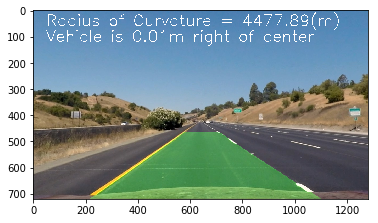

In [17]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/straight_lines1_undist.jpg', undist)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/straight_lines1_out.jpg', lines_img)

# Apply to all the test images

True

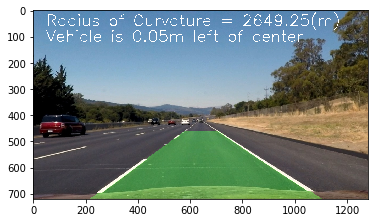

In [18]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/straight_lines2_out.jpg', lines_img)

True

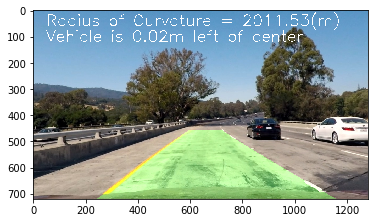

In [19]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test1.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test1_out.jpg', lines_img)

True

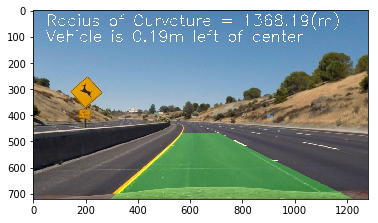

In [20]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test2.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test2_out.jpg', lines_img)

True

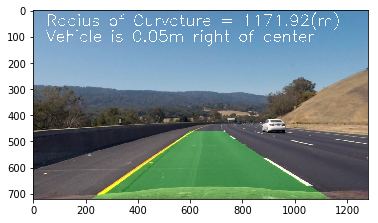

In [21]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test3.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test3_out.jpg', lines_img)

True

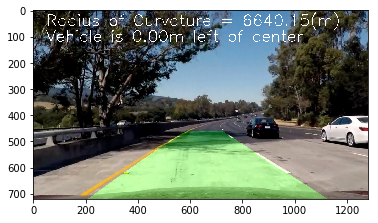

In [22]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test5.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#convert the image to undistort version
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test5_out.jpg', lines_img)

True

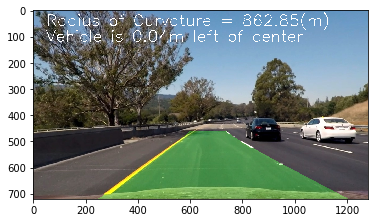

In [23]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test6.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test6_out.jpg', lines_img)

True

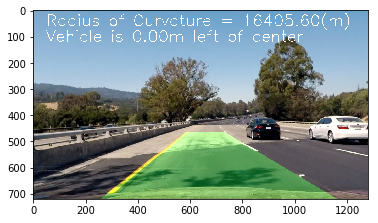

In [24]:
image = cv2.imread('../CarND-Advanced-Lane-Lines/test_images/test4.jpg')
#image = mpimg.imread('../CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
undist = cv2.undistort(image, mtx, dst, None, mtx)
lines_img = pipeline(undist)
lines_img_show = cv2.cvtColor(lines_img, cv2.COLOR_BGR2RGB)
plt.imshow(lines_img_show)
cv2.imwrite('../CarND-Advanced-Lane-Lines/output_images/test4_out.jpg', lines_img)

# Now on the video

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
video_output = '../CarND-Advanced-Lane-Lines/output_video/project_video_output.mp4'
clip = VideoFileClip('../CarND-Advanced-Lane-Lines/project_video.mp4')
project_clip = clip.fl_image(pipeline)
%time project_clip.write_videofile(video_output, audio = False)

[MoviePy] >>>> Building video ../CarND-Advanced-Lane-Lines/output_video/project_video_output.mp4
[MoviePy] Writing video ../CarND-Advanced-Lane-Lines/output_video/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:34<00:00,  5.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../CarND-Advanced-Lane-Lines/output_video/project_video_output.mp4 

CPU times: user 3min 7s, sys: 49.4 s, total: 3min 56s
Wall time: 3min 35s
